### Does increased lexical diversity in lyrics predict song hotness? What about artist hotness?

In [1]:
import pandas as pd
import sqlite3
from nltk.corpus import stopwords

### Background

Information about musiXmatch can be found at http://labrosa.ee.columbia.edu/millionsong/musixmatch

The MSD team partnered with musiXmatch to create a dataset that provides lyrics for many of the MSD tracks. The lyrics come in bag-of-words format: each track is described as the word-counts for a dictionary of the top 5000 words across the set. 

This dataset is available in two formats: 

1. As two text files, a training set and a test set
3. As a SQLite database

Their suggestion is to use the SQLite version. It's faster and "more convenient" (I'm not sure what more convenient describes)

We create a connection to the musiXmatch dataset, and look at the sqlite_master table, which defines the database schema.

In [2]:
conn_lyrics = sqlite3.connect('../Data/mxm_dataset.db')
res = conn_lyrics.execute("Select * FROM sqlite_master where type = 'table'")
res.fetchall()

[('table', 'words', 'words', 2, 'CREATE TABLE words (word TEXT PRIMARY KEY)'),
 ('table',
  'lyrics',
  'lyrics',
  4,
  'CREATE TABLE lyrics (track_id, mxm_tid INT, word TEXT, count INT, is_test INT, FOREIGN KEY(word) REFERENCES words(word))')]

We have two tables: words and lyrics.

The words table has a single column, word.

The lyrics table has five columns:

* track_id: MSD song id
* mxm_tid: musiXmatch track id
* word: one of the words in the table words
* count: the word count for that track
* is_test: tells you if a track is in the test set(1) or not(0)

You can also view that tables by selecting name.

In [4]:
res = conn_lyrics.execute("SELECT name FROM sqlite_master where type = 'table'")
res.fetchall()

[('words',), ('lyrics',)]

## Table Exploration

Lets explore the words table a little bit. The first thing we want to do is find out how many rows it contains.

In [5]:
df_words = pd.read_sql("SELECT word FROM words", con = conn_lyrics)

In [6]:
len(df_words)

5000

We take a look at the table. As said, there's a single column, word. The words have been stemmed, which is the process of reducing words to their root form. See https://en.wikipedia.org/wiki/Stemming

In [7]:
df_words.tail(10)

,word
4990,writer
4991,motivo
4992,bake
4993,insist
4994,wel
4995,santo
4996,pe
4997,gee
4998,colleg
4999,kad


Next let's look at the lyrics table.

In [8]:
df_lyrics = pd.read_sql("SELECT * FROM lyrics", con = conn_lyrics)

In [9]:
len(df_lyrics)

19045332

In [10]:
df_lyrics.head(10)

,track_id,mxm_tid,word,count,is_test
0,TRAAAAV128F421A322,4623710,i,6,0
1,TRAAAAV128F421A322,4623710,the,4,0
2,TRAAAAV128F421A322,4623710,you,2,0
3,TRAAAAV128F421A322,4623710,to,2,0
4,TRAAAAV128F421A322,4623710,and,5,0
5,TRAAAAV128F421A322,4623710,a,3,0
6,TRAAAAV128F421A322,4623710,me,1,0
7,TRAAAAV128F421A322,4623710,it,1,0
8,TRAAAAV128F421A322,4623710,my,1,0
9,TRAAAAV128F421A322,4623710,is,2,0


There are 19,045,332 records in the lyrics table. Each row is composed of a track id, a musiXmatch id, a word, the number of times it appears in the track, and whether the track is part of the test set. Let's look at the entire set of words in track TRAAAAV128F421A322.

In order to use variable names in sqlite queries we use parameter subsitition (see syntax below). 

In [11]:
track = 'TRAAAAV128F421A322'
res = conn_lyrics.execute("SELECT track_id, word, count FROM lyrics WHERE track_id = ?", [track])
res.fetchall()

[('TRAAAAV128F421A322', 'i', 6),
 ('TRAAAAV128F421A322', 'the', 4),
 ('TRAAAAV128F421A322', 'you', 2),
 ('TRAAAAV128F421A322', 'to', 2),
 ('TRAAAAV128F421A322', 'and', 5),
 ('TRAAAAV128F421A322', 'a', 3),
 ('TRAAAAV128F421A322', 'me', 1),
 ('TRAAAAV128F421A322', 'it', 1),
 ('TRAAAAV128F421A322', 'my', 1),
 ('TRAAAAV128F421A322', 'is', 2),
 ('TRAAAAV128F421A322', 'of', 3),
 ('TRAAAAV128F421A322', 'your', 1),
 ('TRAAAAV128F421A322', 'that', 1),
 ('TRAAAAV128F421A322', 'are', 2),
 ('TRAAAAV128F421A322', 'we', 2),
 ('TRAAAAV128F421A322', 'am', 2),
 ('TRAAAAV128F421A322', 'will', 2),
 ('TRAAAAV128F421A322', 'for', 4),
 ('TRAAAAV128F421A322', 'be', 1),
 ('TRAAAAV128F421A322', 'have', 2),
 ('TRAAAAV128F421A322', 'so', 1),
 ('TRAAAAV128F421A322', 'this', 1),
 ('TRAAAAV128F421A322', 'like', 2),
 ('TRAAAAV128F421A322', 'de', 1),
 ('TRAAAAV128F421A322', 'up', 1),
 ('TRAAAAV128F421A322', 'was', 2),
 ('TRAAAAV128F421A322', 'if', 1),
 ('TRAAAAV128F421A322', 'got', 1),
 ('TRAAAAV128F421A322', 'would'

## Calculating Lexical Diversity

The measure of lexical diversity is calculated as follows:

(number of words in a text)/(number of unique words in a text)

We can get this information using a sql query

In [12]:
df_diversity = pd.read_sql('SELECT track_id, \
                                   sum(count) as total_words, \
                                   count(track_id) as unique_words, \
                                   (sum(count)*1.0)/(count(track_id)) as lexical_diversity \
                           FROM lyrics GROUP BY track_id', con = conn_lyrics)

In [13]:
df_diversity.head(10)

,track_id,total_words,unique_words,lexical_diversity
0,TRAAAAV128F421A322,103,68,1.514706
1,TRAAABD128F429CF47,226,74,3.054054
2,TRAAAED128E0783FAB,421,120,3.508333
3,TRAAAEF128F4273421,139,59,2.355932
4,TRAAAEW128F42930C0,115,63,1.825397
5,TRAAAFD128F92F423A,160,82,1.951220
6,TRAAAGF12903CEC202,21,19,1.105263
7,TRAAAHJ128F931194C,172,80,2.150000
8,TRAAAHZ128E0799171,650,224,2.901786
9,TRAAAJG128F9308A25,116,56,2.071429


In [14]:
len(df_diversity)

237662

There are 237,662 tracks with lyrics. They need to be cross referenced with the million songs subset in order to append song_hotness and run a simple regression analysis to determine whether there is a relationship between song_hotness and lexical diversity. 

To do this, we need to open the track_metadata database, which has the track_id and the song_id. The data with the song_hotness variable is from the million song subset.

### bring in track_metadata

In [15]:
conn_meta = sqlite3.connect('../Data/track_metadata.db')
res = conn_meta.execute("Select * FROM sqlite_master where type = 'table'")
res.fetchall()

[('table',
  'songs',
  'songs',
  2,
  'CREATE TABLE songs (track_id text PRIMARY KEY, title text, song_id text, release text, artist_id text, artist_mbid text, artist_name text, duration real, artist_familiarity real, artist_hotttnesss real, year int, track_7digitalid int, shs_perf int, shs_work int)')]

In [16]:
df_track_song = pd.read_sql("SELECT track_id, song_id FROM songs", con = conn_meta)

In [17]:
df_track_song.head(10)

,track_id,song_id
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF
5,TRMMMXN128F42936A5,SOZVAPQ12A8C13B63C
6,TRMMMLR128F1494097,SOQVRHI12A6D4FB2D7
7,TRMMMBB12903CB7D21,SOEYRFT12AB018936C
8,TRMMMHY12903CB53F1,SOPMIYT12A6D4F851E
9,TRMMMML128F4280EE9,SOJCFMH12A8C13B0C2


### bring in mss_df_hotness

In [18]:
save_load_path = '../Data/MillionSongSubset/data'
df_hotness = pd.read_pickle(save_load_path+'/mss_df_hotness.pkl')

In [19]:
list(df_hotness.columns.values)

['song_id', 'song_hotttnesss', 'title']

In [20]:
df_hotness.head()

,song_id,song_hotttnesss,title
0,b'SOMZWCG12A8C13C480',0.602120,"b""I Didn't Mean To"""
1,b'SOCIWDW12A8C13D406',NaN,b'Soul Deep'
2,b'SOXVLOJ12AB0189215',NaN,b'Amor De Cabaret'
3,b'SONHOTT12A8C13493C',NaN,b'Something Girls'
4,b'SOFSOCN12A8C143F5D',0.604501,b'Face the Ashes'


In [21]:
df_hotness['song_id']= df_hotness['song_id'].map(lambda x: str(x)[2:len(x)+2])
df_hotness['title']= df_hotness['title'].map(lambda x: str(x)[2:len(x)+2])

In [22]:
df_hotness.head()

,song_id,song_hotttnesss,title
0,SOMZWCG12A8C13C480,0.602120,I Didn't Mean To
1,SOCIWDW12A8C13D406,NaN,Soul Deep
2,SOXVLOJ12AB0189215,NaN,Amor De Cabaret
3,SONHOTT12A8C13493C,NaN,Something Girls
4,SOFSOCN12A8C143F5D,0.604501,Face the Ashes


In [23]:
df = df_hotness.merge(df_track_song, on='song_id')

In [24]:
df.head()

,song_id,song_hotttnesss,title,track_id
0,SOMZWCG12A8C13C480,0.602120,I Didn't Mean To,TRAAAAW128F429D538
1,SOCIWDW12A8C13D406,NaN,Soul Deep,TRAAABD128F429CF47
2,SOXVLOJ12AB0189215,NaN,Amor De Cabaret,TRAAADZ128F9348C2E
3,SONHOTT12A8C13493C,NaN,Something Girls,TRAAAEF128F4273421
4,SOFSOCN12A8C143F5D,0.604501,Face the Ashes,TRAAAFD128F92F423A


In [25]:
df2 = df_diversity.merge(df, on='track_id')

In [26]:
df2

,track_id,total_words,unique_words,lexical_diversity,song_id,song_hotttnesss,title
0,TRAAABD128F429CF47,226,74,3.054054,SOCIWDW12A8C13D406,NaN,Soul Deep
1,TRAAAEF128F4273421,139,59,2.355932,SONHOTT12A8C13493C,NaN,Something Girls
2,TRAAAFD128F92F423A,160,82,1.951220,SOFSOCN12A8C143F5D,0.604501,Face the Ashes
3,TRAAARJ128F9320760,203,91,2.230769,SOIAZJW12AB01853F1,0.265861,Pink World
4,TRAABJV128F1460C49,189,86,2.197674,SOBONFF12A6D4F84D8,NaN,Tonight Will Be Alright
5,TRAABLR128F423B7E3,210,102,2.058824,SOHUOAP12A8AE488E9,0.405116,Floating
6,TRAABVM128F92CA9DC,325,119,2.731092,SOXLBJT12A8C140925,0.684136,Caught In A Dream
7,TRAACER128F4290F96,255,122,2.090164,SOBBUGU12A8C13E95D,0.666528,Setting Fire to Sleeping Giants
8,TRAACFV128F935E50B,254,76,3.342105,SOBLGCN12AB0183212,0.495294,James (Hold The Ladder Steady)
9,TRAACHN128F1489601,165,69,2.391304,SOPSWQW12A6D4F8781,0.375984,Made Like This (Live)


Lets check this to make sure the merges worked properly.

We'll take row with index 3.

In [27]:
df2.iloc[[(3)]]

,track_id,total_words,unique_words,lexical_diversity,song_id,song_hotttnesss,title
3,TRAAARJ128F9320760,203,91,2.230769,SOIAZJW12AB01853F1,0.265861,Pink World


First we query the df_hotness using the song_id to make sure the values match up.

In [28]:
df_hotness.query("song_id =='SOIAZJW12AB01853F1'")

,song_id,song_hotttnesss,title
8,SOIAZJW12AB01853F1,0.265861,Pink World


Next we query df_track_song using the song_id

In [31]:
df_track_song.query("song_id =='SOIAZJW12AB01853F1'")

,track_id,song_id
440382,TRAAARJ128F9320760,SOIAZJW12AB01853F1


Last we query df_diversity to make sure it's pulling the right track data.

In [32]:
df_diversity.query("track_id =='TRAAARJ128F9320760'")

,track_id,total_words,unique_words,lexical_diversity
11,TRAAARJ128F9320760,203,91,2.230769


Confidence has increased in using the merge function (which I wish had taken less time to find).

Finally, lets remove rows without a song_hotttnesss value. This results in 1,692 rows.

In [33]:
df2 = df2[df2.song_hotttnesss.notnull()]
len(df2)

1692

## Simple Linear Regression

Finally, we can run our regression. 

In [34]:
import numpy as np
#from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


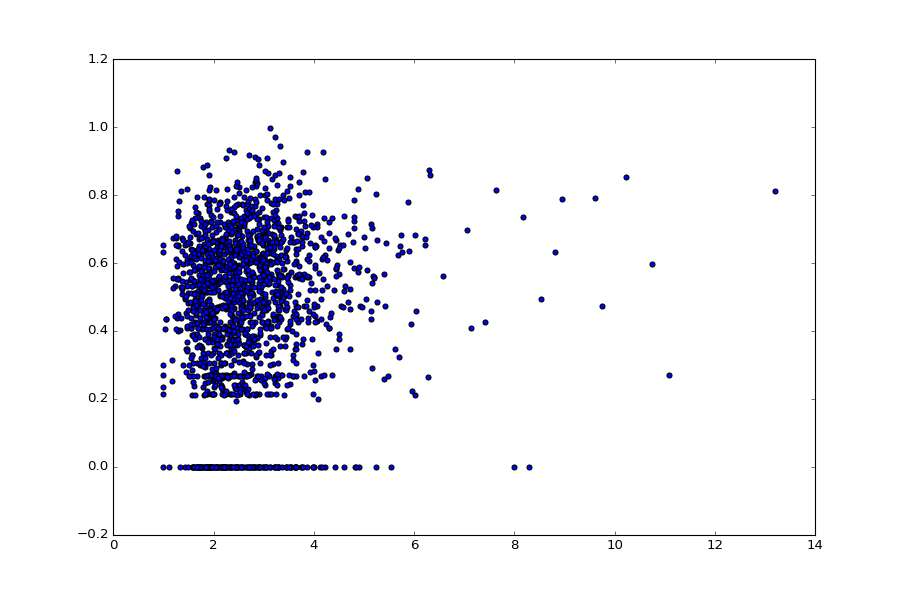

In [45]:
plt.scatter(df2.lexical_diversity, df2.song_hotttnesss)
plt.show()

In [36]:
x = df2.lexical_diversity[:-1]
y = df2.song_hotttnesss[:-1]

In [48]:
model = sm.OLS(y, x)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        song_hotttnesss   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     4788.
Date:                Mon, 29 Feb 2016   Prob (F-statistic):               0.00
Time:                        15:23:25   Log-Likelihood:                -182.53
No. Observations:                1691   AIC:                             367.1
Df Residuals:                    1690   BIC:                             372.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
lexical_diversity     0.1545      0.002     69.198      0.000         0.150     0.159
==============================================================================
Omnibus:                      274.542   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              528.131
Skew:                          -0.983   Prob(JB):                    2.08e-115
Kurtosis:                       4.906   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Stop Here

In [38]:
rnd = np.random.rand(len(df2)) < 0.7

In [39]:
train = df2[rnd]
test = df2[~rnd]

In [40]:
len(train), len(test)

(1186, 506)

In [41]:
train_x = train['lexical_diversity']
test_x = test['lexical_diversity']

train_y = train['song_hotttnesss']
test_y = test['song_hotttnesss']

In [42]:
stop = stopwords.words('english')
new_list = (df_words['word'])
sum(df_words['word'].isin(stop))
type(new_list), len(new_list), new_list.head(5)

(pandas.core.series.Series, 5000, 0      i
 1    the
 2    you
 3     to
 4    and
 Name: word, dtype: object)